# Bias over time

### requirements:
You need the data for the paper loaded next to the scripts.
This script uses the folder DEPOISBIASExtraData, with population data for each algorithm run.
It calculates for each 100 evaluations the bias statistic and creates many plots.

In [6]:
%matplotlib inline
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import adjusted_mutual_info_score, pairwise_distances_argmin_min, pairwise_distances
import pandas as pd
from IPython.core.debugger import set_trace
from scipy.stats import anderson
from scipy.stats import norm
from scipy.stats import anderson_ksamp
from statsmodels.stats.multitest import multipletests
def statstical_bias_fixed(X, alpha: float=0.05, dim: int = 30, adjust_pvalue: bool = False):
    """Statistical Bias (SB) measure as in 
    
    Kononova, Anna V., Fabio Caraffini, Hao Wang, and Thomas Bäck. 
    "Can compact optimisation algorithms be structurally biased?." 
    In International Conference on Parallel Problem Solving from Nature,
    pp. 229-242. Springer, Cham, 2020.
    
    Parameters
    ----------
    X : pd.DataFrame
        data frame containing the last points of f_0 from multiple runs, of shape (N_run, dim)
    alpha : float
        the significance level
    dim : int
        the dimensonality of the last points
    adjust_pvalue: bool
        should the p values be adjusted using the FDR (false discover rate) control?
    """
    _support_sig_levels = np.array([25, 10, 5, 2.5, 1, 0.5, 0.1]) / 100
    assert alpha in set(_support_sig_levels)
    
    sample_unif = np.random.rand(int(1e3))
    X_ = X.T
    
    N = X_.shape[0]
    A2, pvalues = np.zeros(N), np.zeros(N)
    for i, x in enumerate(X_):
        A2[i], _, pvalues[i] = anderson_ksamp([x, sample_unif])
    
    if adjust_pvalue:
        rejects = multipletests(pvalues, alpha=alpha, method='fdr_by')[0]
    else:
        rejects = pvalues < alpha
    A2_ = A2[rejects]
    return np.mean(A2_) if len(A2_) > 0 else 0

In [39]:
#parse DEPOISBIASExtraData and calculate for each 100 evaluations the bias statistic
import os
from tqdm.notebook import tqdm
import re
import copy

pattern = re.compile("(\w+?)(\d+)D30f0-(\d+)F([\d\.]+)Cr(\d+\.\d+)")

interesting_features = ["1", "2", "3", "4","5","6","7","8","9","10","11","12","13","14","15",
            "16","17","18","19","20","21","22","23","24","25","26","27","28","29","30"]

all_evil_datas = {}

#this takes a lot of main memory, you can also first only do directory 7, and then 8 and 9 for example.
#Make sure the data from DEPOISBIASExtraData is at the same level as this script
for C in tqdm([7,8,9]):
    if C == 7:
        features = ['ID','p1_ID','p2_ID','p3_ID', 'fitness', 'eval', 'replaced', "1", "2", "3", "4","5","6","7","8","9","10","11","12","13","14","15",
            "16","17","18","19","20","21","22","23","24","25","26","27","28","29","30"]
    if C == 8:
        features = ['ID','p1_ID','p2_ID','p3_ID', 'p4_ID', 'fitness', 'eval', 'replaced', "1", "2", "3", "4","5","6","7","8","9","10","11","12","13","14","15",
            "16","17","18","19","20","21","22","23","24","25","26","27","28","29","30"]
    if C == 9:
        features = ['ID','p1_ID','p2_ID','p3_ID', 'p4_ID', 'p5_ID', 'fitness', 'eval', 'replaced', "1", "2", "3", "4","5","6","7","8","9","10","11","12","13","14","15",
            "16","17","18","19","20","21","22","23","24","25","26","27","28","29","30"]
    
    
    
    for filename in tqdm(os.listdir('DEPOISBIASExtraData/'+str(C)+'/'), leave=False):
        #if "DEbobsp5D" not in filename:
        #    continue
            
        
        res = pattern.search(filename)
        #print(filename)
        if (res != None):
            
            alg = res.group(1)
            pop = int(res.group(2))
            
            
            run_number = int(res.group(3))
            F = float(res.group(4))
            Cr = float(res.group(5))
            old_eval = pop
            
            evil_key = alg + str(pop) + '-' + str(F) + '-' + str(Cr)
            
            #check if we have it already or not
            if evil_key not in all_evil_datas.keys():
                all_evil_datas[evil_key] = np.zeros((3000,pop*100, 30))
            
            #print(alg,pop,F,Cr)
            df = pd.read_csv('/Users/basvanstein/Dropbox/Universiteit/Anna papers/DEPOISBIASExtraData/'+str(C)+'/'+filename, delimiter = " ", skiprows=1, header=None, names=features)
            active_population = {}

            for index, row in df.iterrows():
                #print('eval', index,)
                i_id = int(row['ID'])
                i = row[interesting_features].values
                replace = int(row['replaced'])
                new_eval = int(row['eval'])
                
                
                active_population[i_id] = i
                
                if len(active_population.values()) > pop:
                    if replace in active_population.keys():
                        del active_population[replace]
                    for j in np.arange(old_eval, new_eval, 100):
                        evil_j = int(j / 100)
                        all_evil_datas[evil_key][evil_j,(run_number-1)*pop:run_number*pop] = list(active_population.values())
                    old_eval = new_eval
                    #print('active_pop',active_population)
                    #print('eval_pop',eval_populations)
            for j in np.arange(old_eval, 300000, 100):
                evil_j = int(j / 100)
                all_evil_datas[evil_key][evil_j,(run_number-1)*pop:run_number*pop] = list(active_population.values())

print(evil_data.shape)




(3000, 500, 30)


In [41]:
print(all_evil_datas.keys())

dict_keys(['DErtbsp100-1.783-0.99', 'DErtbsp5-1.783-0.99', 'DEbtbsp5-0.7-0.52', 'DEbtesp5-0.916-0.99', 'DErtbsp20-1.783-0.99', 'DErtesp100-1.133-0.99', 'DErtbsp5-1.133-0.52', 'DErtbsp100-1.133-0.52', 'DErtbsp20-1.133-0.52', 'DEbtbsp5-1.783-0.99', 'DErtbsp20-1.783-0.52', 'DErtbsp100-1.133-0.99', 'DErtbsp20-1.133-0.99', 'DErtbsp100-1.783-0.52', 'DEbtbsp5-1.783-0.52', 'DErtbsp5-1.783-0.52', 'DErtesp100-1.783-0.99', 'DErtbsp5-1.133-0.99', 'DEbtesp5-1.783-0.99', 'DEbtbsp5-0.7-0.99'])


In [ ]:
#specific plots for the paper
specific_keys_DErtbsp5 = ['DErtbsp5-1.783-0.99', 'DErtbsp5-1.133-0.52', 'DErtbsp5-1.783-0.52', 'DErtbsp5-1.133-0.99', 'DErtbsp20-1.133-0.99', 'DErtbsp100-1.133-0.99', 'DErtbsp20-1.133-0.99']
specific_keys_DErtbsPs = ['DErtbsp20-1.133-0.99', 'DErtbsp100-1.133-0.99', 'DErtbsp20-1.133-0.99']

all_stats = {}
pattern2 = re.compile("(\w+?)(\d+).*")
for algkey in specific_keys_DErtbsp5:
    stats = []
    evil_data = all_evil_datas[algkey]

    res = pattern2.search(algkey)
    algname = res.group(1)
    pop = int(res.group(2))
    #print(evil_data[r,:,:])
    for r in tqdm(np.arange(pop, len(evil_data))):
        sample = evil_data[r,:,:]
        stats.append(statstical_bias_fixed(sample))
    all_stats[algkey] = copy.deepcopy(stats)



In [48]:
#specific images for the paper
plt.figure(figsize=(8,6))
plt.scatter(np.arange(len(all_stats['DErtbsp5-1.783-0.99'])),all_stats['DErtbsp5-1.783-0.99'], s=5, marker='*', label='F=1.78, Cr=0.99')
plt.scatter(np.arange(len(all_stats['DErtbsp5-1.133-0.52'])),all_stats['DErtbsp5-1.133-0.52'], s=5, marker='+', label='F=1.13, Cr=0.52')
plt.scatter(np.arange(len(all_stats['DErtbsp5-1.783-0.52'])),all_stats['DErtbsp5-1.783-0.52'], s=5, marker='d', label='F=1.78, Cr=0.52')
plt.scatter(np.arange(len(all_stats['DErtbsp5-1.133-0.99'])),all_stats['DErtbsp5-1.133-0.99'], s=5, marker='x', label='F=1.13, Cr=0.99')
plt.xlabel("Evaluation * 100")
plt.ylabel("Bias statistic")
plt.title("DErtbs P=5")
plt.grid()
plt.legend()
plt.savefig('time-img/combination_DErtbsp5.pdf')
plt.clf()

plt.figure(figsize=(8,6))
plt.scatter(np.arange(len(all_stats['DErtbsp5-1.133-0.99'])),all_stats['DErtbsp5-1.133-0.99'], s=5, marker='*', label='P=5')
plt.scatter(np.arange(len(all_stats['DErtbsp20-1.133-0.99'])),all_stats['DErtbsp20-1.133-0.99'], s=5, marker='+', label='P=20')
plt.scatter(np.arange(len(all_stats['DErtbsp100-1.133-0.99'])),all_stats['DErtbsp100-1.133-0.99'], s=5, marker='d', label='P=100')
plt.xlabel("Evaluation * 100")
plt.ylabel("Bias statistic")
plt.title("DErtbs F=1.13 Cr=0.99")
plt.grid()
plt.legend()
plt.savefig('time-img/combination_DErtbspvari.pdf')
plt.clf()

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

In [ ]:
# all images of bias over time
import seaborn as sns

pattern2 = re.compile("(\w+?)(\d+).*")
for alg in all_evil_datas.keys():
    stats = []
    evil_data = all_evil_datas[alg]
    print(alg)
    res = pattern2.search(alg)
    algname = res.group(1)
    pop = int(res.group(2))
    #print(evil_data[r,:,:])
    for r in tqdm(np.arange(pop, len(evil_data))):
        sample = evil_data[r,:,:]
        stats.append(statstical_bias_fixed(sample))
    
    plt.figure(figsize=(8,6))
    plt.scatter(np.arange(len(stats)),stats, s=2)
    plt.xlabel("Evaluation * 100")
    plt.ylabel("Bias statistic")
    plt.title(alg)
    plt.grid()
    plt.savefig('time-img/'+alg+'.pdf')
    plt.savefig('time-img/'+alg+'.png')
    plt.clf()

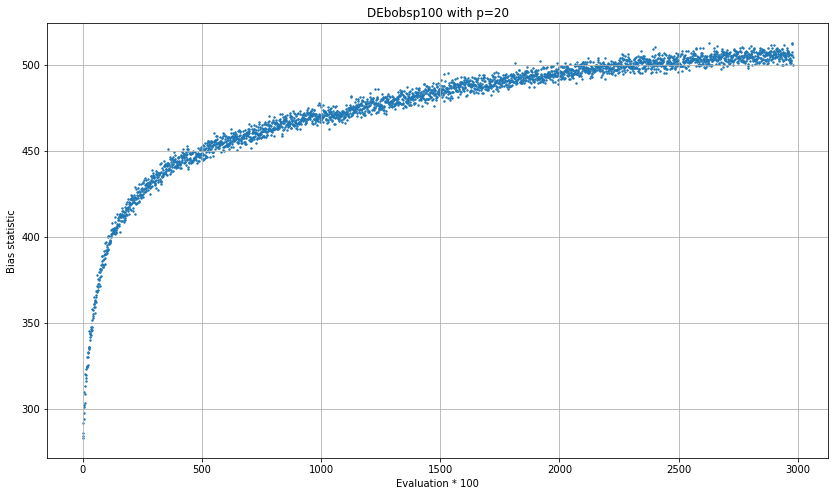

<Figure size 432x288 with 0 Axes>

In [25]:
#test
import seaborn as sns

plt.figure(figsize=(14,8))
plt.scatter(np.arange(len(stats)),stats, s=2)
plt.xlabel("Evaluation * 100")
plt.ylabel("Bias statistic")
plt.title(alg + " with p="+str(pop))
plt.grid()
plt.show()
plt.clf()

In [ ]:
sf = pd.DataFrame(all_data, columns=['alg', 'pop', 'F', 'Cr', 'run_number', 'evals'])
sf